# Multi headed DNN predictor, detects object coordinates, color and shape type

Toy DNN to demostrate the usage of the multi headed output in keras.
The task is to learn to detect basic shapes (circle, triangel, rectangle...and color) and position coordinates.

Steps:
- Create toy database, generate shapes, color it
- Normalize the generated images
- Create the multiheaded Keras functional model, train and test it

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import cv2

import os
import glob

configproto = tf.compat.v1.ConfigProto() 
configproto.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=configproto) 
tf.compat.v1.keras.backend.set_session(sess)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Num GPUs Available:  1


## Create a toy database
- Input image is 128x128x3 image, generate n samples (rectangles/circles, triangles with different size) store it in a numpy array
- Compute the center points, store it together with shape type and color


In [16]:
samples = 1000
w,h = 128,128
obj_min_size = 30
obj_max_size = 60
nr_shape_type = 3
nr_shape_color = 6
stype_lab = ['circle','rectangle', 'triangle']
scolor_lab = ['Red','Green','Blue','Yellow','Pink', 'Cyan']


def gen_traning_data(samples_nr=1000, iw=128,ih=128,obj_min=30,obj_max=60):
    """ generate traning data - rectangles with different size, return img and position"""
    
    imgs = np.zeros((samples_nr,iw,ih,3),dtype=np.uint8)
    pos = np.zeros((samples_nr,2))
    shapetype = np.zeros((samples_nr,3))
    shapecolor = np.zeros((samples_nr,6))
    colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255]]
    
    # encode the colors
    def one_hot(val):
        arr = [0,0,0,0,0,0]
        arr[val] = 1
        return arr
            
    # generate random samples
    for i in range (samples_nr):
        # generate basic shape information
        ow = np.random.randint(obj_min,obj_max,dtype=np.uint8)
        oh = np.random.randint(obj_min,obj_max,dtype=np.uint8)
        oposx = np.random.randint(int(ow/2),iw-ow,dtype=np.uint8)
        oposy = np.random.randint(int(oh/2),ih-oh,dtype=np.uint8)
        
        # generate random between [0,5]
        clord = np.random.randint(0,6,dtype=np.uint8)
        color = colors[clord]

        # 0 - circle, 1 - retangle , 2 - triangle
        k = np.random.randint(0,3,dtype=np.uint8)

        if k == 0:
            r = int(min(ow/2,oh/2))
            cv2.circle(imgs[i],(oposx,oposy),r,color,-1)
            pos[i,] = oposx,oposy
            shapetype[i,] = np.array([1,0,0])
            shapecolor[i,]= one_hot(clord)
        elif k==1:
            cv2.rectangle(imgs[i],(oposx,oposy),(oposx+ow,oposy+oh),color,-1)
            pos[i,] = oposx + int(ow/2),oposy + int(oh/2)
            shapetype[i,] = np.array([0,1,0])
            shapecolor[i,]= one_hot(clord)
        elif k==2:
            triangle_points= np.array([[oposx,oposy],[oposx+ow,oposy],[oposx,oposy+oh]],dtype=np.int32)
            cv2.drawContours(imgs[i], [triangle_points], 0, color, -1)
            pos[i,] = int(oposx+ow/4), int(oposy+oh/4)
            shapetype[i,] = np.array([0,0,1])
            shapecolor[i,]= one_hot(clord)
                         
    return imgs,pos,shapetype,shapecolor

imgs,pos,shapetype,shapecolor = gen_traning_data(samples_nr=samples,iw=w,ih=h,obj_min=obj_min_size,obj_max=obj_max_size)

print (imgs.shape,pos.shape)

(1000, 128, 128, 3) (1000, 2)


circle, triangle, triangle, rectangle, rectangle, circle, rectangle, circle, rectangle, rectangle, Blue, Blue, Red, Green, Blue, Cyan, Pink, Cyan, Blue, Yellow, 

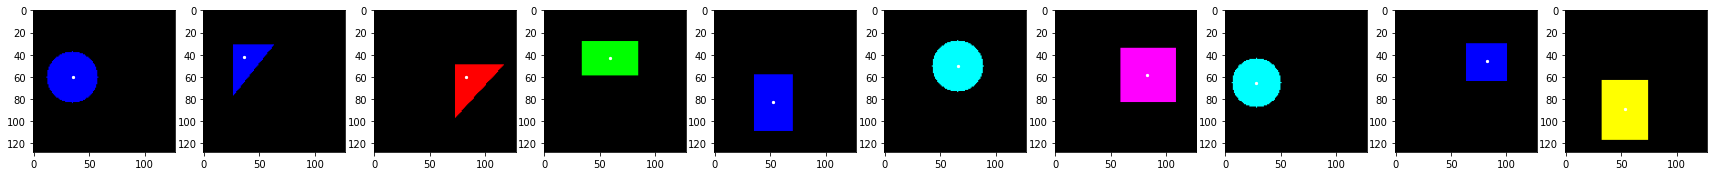

In [17]:
def plot_data(indx,imgarr,posarr):
    #plot image, plt keypoints
    plt.rcParams["figure.figsize"] = (30,3)
    if indx is not None:
        plt.imshow(imgarr[indx], cmap='Greys')
        plt.scatter(posarr[indx,0], posarr[indx,1],s=20, marker='.', c='w')
    else:
        # draw a array of plots
        fig, axs = plt.subplots(1, len(imgarr))
        
        for i, ax in enumerate(axs):
            ax.imshow(imgarr[i])
            ax.scatter(posarr[i,0], posarr[i,1],s=20, marker='.', c='w')

# generate 10 samples
plot_data(None,imgs[0:10],pos[0:10])

# display labels
for e in shapetype[0:10]:
    max_pos = np.argmax(e, axis=0)
    print (stype_lab[max_pos], end=", ")

for e in shapecolor[0:10]:
    max_pos = np.argmax(e, axis=0)
    print (scolor_lab[max_pos], end=", ")

## Create a fuctional keras model to handle detections

First target was to create a slim model (below 300k of weights), with a 'good enough' detection accuracy

Inpus are:
- image -  nx128x128x3
Output:
 - position
 - shape type
 - color

Preprocess:
- before processing the image will be normalized, using (val - mean) / sdt
- positional information will be normalized beteen (0,1)
- split created data to train and validation

In [18]:
# normalize images
X = (imgs.reshape(samples,-1) - np.mean(imgs))/np.std(imgs)

# normalize position information
y_pos = pos.reshape(samples,-1) / h

# normalize shape type info
y_type = shapetype

# normalize color info
y_color = shapecolor

# print shapes values
X.shape, y_pos.shape, y_type.shape,y_color.shape, np.mean(imgs), np.std(imgs)

((1000, 49152),
 (1000, 2),
 (1000, 3),
 (1000, 6),
 11.031146850585937,
 51.87731918729141)

In [19]:
# create the DNN functinal model
image_in = keras.layers.Input(shape=(w,h,3))

# coordinte prediction
#---------------------
xi = keras.layers.Conv2D(32,(10,10),activation='relu') (image_in)
xi = keras.layers.MaxPool2D(2,2)(xi)
xi = keras.layers.Conv2D(64,(3,3),activation='relu') (xi)
xi = keras.layers.MaxPool2D(2,2)(xi)
xi = keras.layers.Conv2D(64,(3,3),activation='relu') (xi)
xi = keras.layers.MaxPool2D(2,2)(xi)

xi = keras.layers.Conv2D(128,(2,2),activation='relu') (xi)
xi = keras.layers.MaxPool2D(2,2)(xi)

xi = keras.layers.Conv2D(32,(3,3),activation='relu') (xi)
xi = keras.layers.MaxPool2D(2,2)(xi)

xi = keras.layers.Conv2D(32,(3,3),activation='relu', padding="same") (xi)
xi = keras.layers.MaxPool2D(2,2,  padding="same")(xi)

xi = keras.layers.Flatten()(xi)

xi = keras.layers.Dense(100, use_bias=True)(xi)
xi = keras.layers.Dense(100, use_bias=True)(xi)

out_pos = keras.layers.Dense(2, use_bias=True,  name='pos')(xi)
# ------------------------
# end coordinte prediction

# shape type predict
# ------------------
xt = keras.layers.Conv2D(32,(10,10),activation='relu') (image_in)
xt = keras.layers.BatchNormalization()(xt)
xt = keras.layers.MaxPool2D(4,4)(xt)

xt = keras.layers.Conv2D(32,(5,5),activation='relu') (xt)
xt = keras.layers.BatchNormalization()(xt)
xt = keras.layers.MaxPool2D(4,4)(xt)

xt = keras.layers.Conv2D(32,(2,2),activation='relu') (xt)
xt = keras.layers.BatchNormalization()(xt)
xt = keras.layers.MaxPool2D(4,4)(xt)

xt = keras.layers.Flatten()(xt)
xt = keras.layers.Dense(100, activation='relu')(xt)

out_stype = keras.layers.Dense(3,  name='stype', activation='softmax')(xt)
# ----------------------
# end shape type predict

# color predict
# -------------
xc = keras.layers.Conv2D(24,(3,3),activation='relu') (image_in)
xc = keras.layers.BatchNormalization()(xc)
xc = keras.layers.MaxPool2D(2,2)(xc)

xc = keras.layers.Conv2D(32,(3,3),activation='relu') (xc)
xc = keras.layers.BatchNormalization()(xc)
xc = keras.layers.MaxPool2D(3,3)(xc)

xc = keras.layers.Conv2D(32,(3,3),activation='relu') (xc)
xc = keras.layers.BatchNormalization()(xc)
xc = keras.layers.MaxPool2D(3,3)(xc)

xc = keras.layers.Conv2D(32,(2,2),activation='relu', padding='same') (xc)
xc = keras.layers.BatchNormalization()(xc)
xc = keras.layers.MaxPool2D(2,2)(xc)


xc = keras.layers.Flatten()(xc)
xc = keras.layers.Dense(32, activation='relu')(xc)

out_scolor = keras.layers.Dense(6,name='scolor',activation='softmax')(xc)
# -----------------
# end color predict



model = keras.Model(inputs=image_in, outputs={'pos':out_pos, 'stype':out_stype, 'scolor':out_scolor})

model.compile('adadelta',loss = {'pos':'mse','stype':'categorical_crossentropy', 'scolor':'categorical_crossentropy'}, metrics={'pos':'acc','stype':'acc','scolor':'acc'})

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 119, 119, 32) 9632        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 59, 59, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 126, 126, 24) 672         input_2[0][0]                    
____________________________________________________________________________________________

## Train the model

In [20]:
steps=40
valsteps=10
epochs=600


class clbck_save(keras.callbacks.Callback):
    def __init__(self, n):
        self.n = float(n)
        self.count = 0
    # print loss every n epochs
    def on_epoch_end(self, epoch, logs={}):
        paccu = logs.get('pos_acc')
        saccu = logs.get('stype_acc')
        caccu = logs.get('scolor_acc')

        self.count +=1
        if paccu >= self.n:
            print ("...saved!")
            model.save('k_'+str(paccu)+"_"+str(saccu)+"_"+str(caccu)+'.h5')


# set target to save the model
myclback = clbck_save(0.95)

print (X.shape)

Xr = X.reshape(len(X),128,128,3)

hist = model.fit(x=Xr,y={'pos':y_pos,'stype':y_type,'scolor':y_color}, steps_per_epoch=steps,validation_steps=valsteps,validation_split=0.2, epochs=epochs, batch_size=16,callbacks=[myclback], verbose=1)

(1000, 49152)
Epoch 1/600
40/40 [==============================] - 4s 101ms/step - loss: 5.9695 - pos_loss: 0.3288 - scolor_loss: 3.7055 - stype_loss: 1.9352 - pos_acc: 0.4781 - scolor_acc: 0.1688 - stype_acc: 0.3203 - val_loss: 3.4895 - val_pos_loss: 0.3197 - val_scolor_loss: 1.9455 - val_stype_loss: 1.2243 - val_pos_acc: 0.4750 - val_scolor_acc: 0.2625 - val_stype_acc: 0.3313
Epoch 2/600
40/40 [==============================] - 4s 93ms/step - loss: 5.8031 - pos_loss: 0.3087 - scolor_loss: 3.6055 - stype_loss: 1.8889 - pos_acc: 0.4641 - scolor_acc: 0.1844 - stype_acc: 0.3313 - val_loss: 3.4692 - val_pos_loss: 0.3005 - val_scolor_loss: 1.9405 - val_stype_loss: 1.2282 - val_pos_acc: 0.4500 - val_scolor_acc: 0.2125 - val_stype_acc: 0.3250
Epoch 3/600
40/40 [==============================] - 4s 92ms/step - loss: 5.7621 - pos_loss: 0.2925 - scolor_loss: 3.5250 - stype_loss: 1.9446 - pos_acc: 0.4625 - scolor_acc: 0.1906 - stype_acc: 0.3141 - val_loss: 3.5197 - val_pos_loss: 0.2827 - val_sco

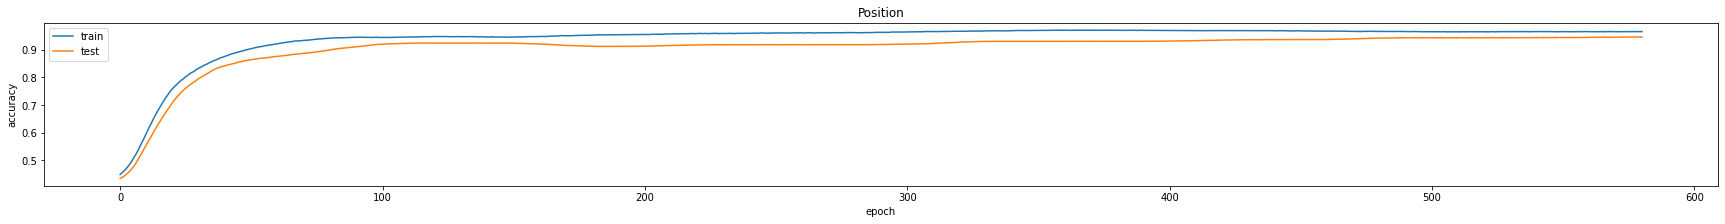

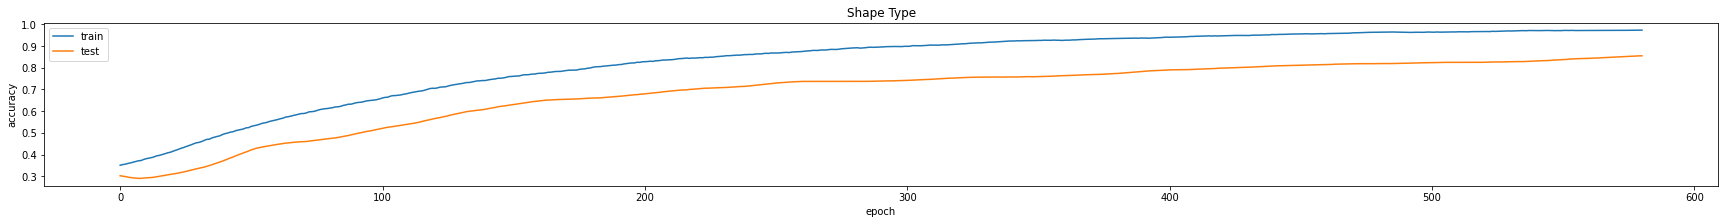

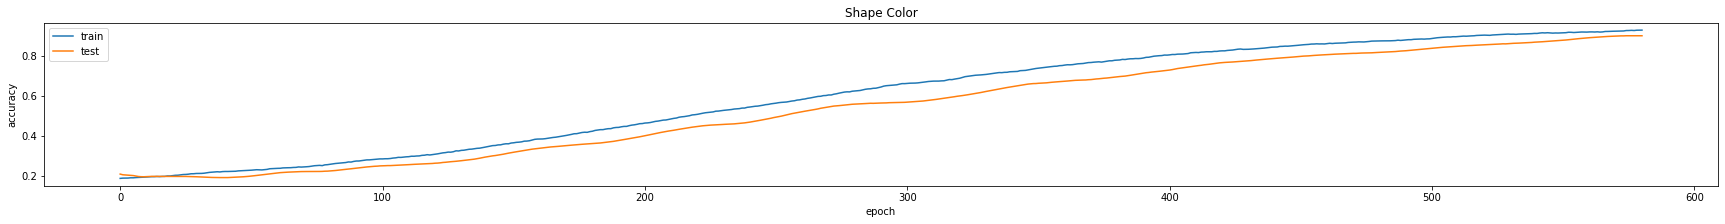

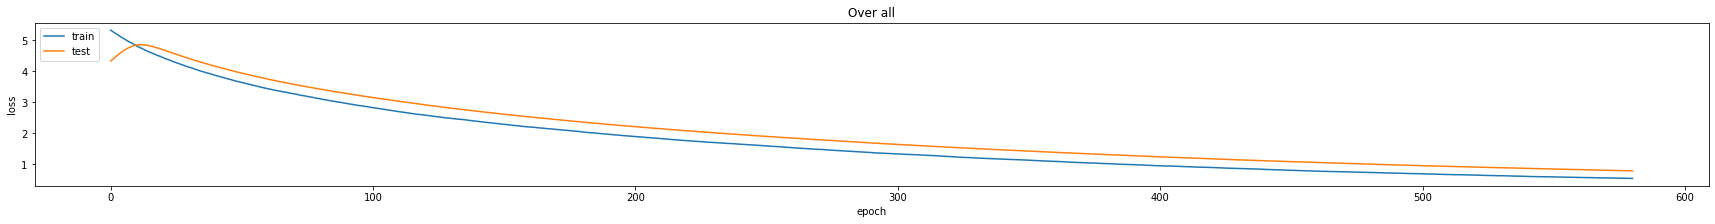

In [23]:
# filter predictions
def mavr(data, win=20):
    return np.convolve(data, np.ones(win), 'valid') / win

plt.plot(mavr(hist.history['pos_acc']))
plt.plot(mavr(hist.history['val_pos_acc']))
plt.title('Position')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(mavr(hist.history['stype_acc']))
plt.plot(mavr(hist.history['val_stype_acc']))
plt.title('Shape Type')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(mavr(hist.history['scolor_acc']))
plt.plot(mavr(hist.history['val_scolor_acc']))
plt.title('Shape Color')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(mavr(hist.history['loss']))
plt.plot(mavr(hist.history['val_loss']))
plt.title('Over all')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test the trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

rectangle, triangle, triangle, triangle, circle, triangle, triangle, circle, rectangle, triangle, Red, Red, Blue, Yellow, Blue, Blue, Cyan, Red, Red, Green, 

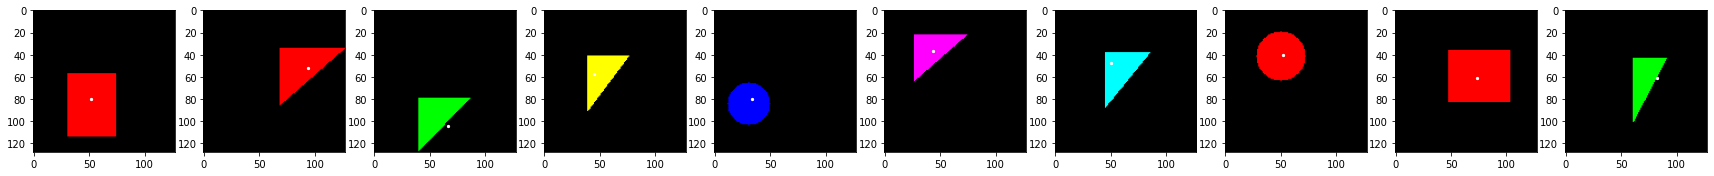

In [26]:
# load traned model

tst_nr = 10
tst_img,tst_pos,tst_stype, tst_scolor = gen_traning_data(samples_nr=tst_nr,obj_max=obj_max_size, obj_min=obj_min_size)

# normalize images
X = (tst_img.reshape(tst_nr,-1) - np.mean(tst_img))/np.std(tst_img)

X = X.reshape(len(X),128,128,3)

y_pred= (model.predict(X))

plot_data(None,X,y_pred['pos']*128)

for e in y_pred['stype']:
    max_pos = np.argmax(e, axis=0)
    print (stype_lab[max_pos], end=", ")

for e in y_pred['scolor']:
    max_pos = np.argmax(e, axis=0)
    print (scolor_lab[max_pos], end=", ")


In [9]:
#model.save('k_3out.h5')